# Setup
## Colab Setup


In [1]:
!pip install ipynb
!pip install nbformat
!pip install git+https://github.com/google-research/timesfm.git
!pip install utilsforecast
!pip install prophet

  Cloning https://github.com/google-research/timesfm.git to /tmp/pip-req-build-6qlmbi4i
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm.git /tmp/pip-req-build-6qlmbi4i
  Resolved https://github.com/google-research/timesfm.git to commit 5c7b905e8deccad1a026a9475b00777fbadc0b18
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached utilsforecast-0.1.12-py3-none-any.whl (40 kB)


In [2]:
import errno, os
import requests
import scipy.io as sio
import numpy as np

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile

# 1. Download the dataset - CWRU

The data set is provided by [Case Western Reserve University](https://engineering.case.edu/bearingdatacenter)
The dataset is downloaded from the [Github](https://github.com/s-whynot/CWRU-dataset) repository.    

For all files, the following item in the variable name indicates:                                      
  
DE - drive end accelerometer data

FE - fan end accelerometer data

BA - base accelerometer data

time - time series data

RPM- rpm during testing

The dataset has several matlab files where the name is just a number (such as "118.mat"). It has information such as
1. **State** -
     - `N` for *normal* state, not damaged
     - `B` for *ball* damage
     - `IR` for *inner raceway* damage
     - `OR` for *outer raceway* damage
2. **Fault Diameter** -
    - `007` for 0.007 inch damage
    - `014` for 0.014 inch damage
    - `021` for 0.021 inch damage
    - `028` for 0.028 inch damage  
    the unit 'mils' is 1/1000th of an inch
3. **Position of the sensor**
    - *3*, *6*, *12* for *outer raceway* faults located at 3 o’clock, at 6 o’clock and at 12 o’clock respectively of the load zone
4. **Load** can be:
    - *0*, *1*, *2*, *3* for different motor load conditions in Horsepower (HP)

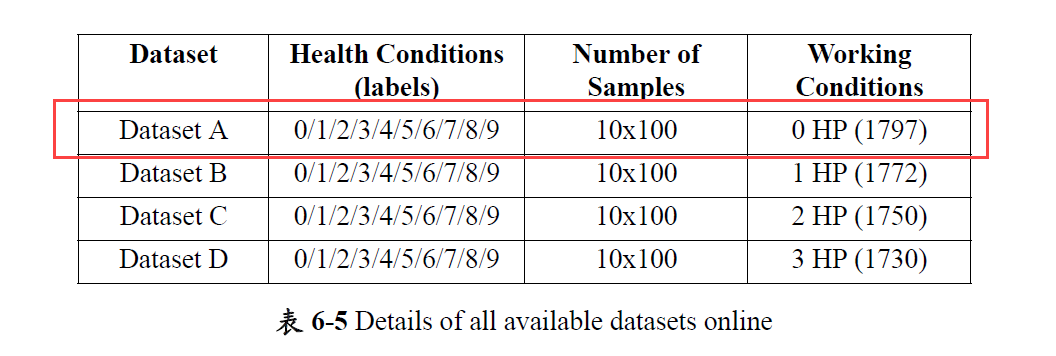

In [3]:
filename = os.path.join(os.getcwd(), 'repo.zip')
url = 'https://github.com/s-whynot/CWRU-dataset/archive/main.zip'

r = requests.get(url)
print(filename)
with open(filename, 'wb') as f:
    f.write(r.content)
    #f.close()

file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    #zip.printdir()

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Finished Extracting!')

/content/repo.zip
Extracting all the files now...
Finished Extracting!


# 2. Extract and edit the downloaded data
Using the data collected at the *Drive End*, which is labeled as the code `DE`, this function picks up the time signal from a file. For the given code, a regex is made on the dictionary keys, looking for the the code and ignoring the rest of the suffix.

The function also converts the unit to SI.

In [4]:
def acceleration_time_signal(dict_1, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """
    import re
    try:
        for key in dict_1:
            if re.findall(rf"({code})", key):
                dict_code = key
        #inches to meter
        unit_conv = 0.0254
        print
        x = dict_1[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')

In [5]:
def Read_MAT_files_from_folders(file_path, files_list, code):
  G_data = []
  for i in range(len(files_list)):
    data = sio.loadmat(os.path.join(file_path, files_list[i]))
    print(file_path, files_list[i])
    # print(data)
    sig = acceleration_time_signal(data, code)
    # print(sig)
    G_data.append(sig)

  G_data = np.vstack(G_data).flatten()
  display(G_data.shape)
  return G_data

def Percent_data_split(array_1, array_2, percent_1=10, index_1 = False):
  if index_1 == False:
    #splitting FE data by percent
    len_n = array_1.shape[0]
    percent_true = percent_1/100
    #print(percent_true)
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])
  else:
    #splitting FE data by percent of DE data
    len_n = array_2.shape[0]
    percent_true = percent_1/100
    #print(percent_true)
    x = int(percent_true*len_n) #% split
    #print(x)
    data_percent, data_rest = np.split(array_1, [x])

  return data_percent, data_rest

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

# 3.1 Read Normal Data From Data set

In [6]:

#12k Normal Signal for FE & DE
file_path_1 = '/content/CWRU-dataset-main/Normal/'
onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]
#print(onlyfiles_1)

G_data_N_DE = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")
G_data_N_FE = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "FE")
display(G_data_N_DE.shape)
display(G_data_N_FE.shape)

/content/CWRU-dataset-main/Normal/ 97_Normal_0.mat
/content/CWRU-dataset-main/Normal/ 100_Normal_3.mat
/content/CWRU-dataset-main/Normal/ 98_Normal_1.mat
/content/CWRU-dataset-main/Normal/ 99_Normal_2.mat


(1698547,)

/content/CWRU-dataset-main/Normal/ 97_Normal_0.mat
/content/CWRU-dataset-main/Normal/ 100_Normal_3.mat
/content/CWRU-dataset-main/Normal/ 98_Normal_1.mat
/content/CWRU-dataset-main/Normal/ 99_Normal_2.mat


(1698547,)

(1698547,)

(1698547,)

# 3.2 Read 12k_Drive_End_Bearing_Fault_Data Data From Data set

In [7]:
#12k DE data load
file_path_2 = '/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/'

# Get a list of all subdirectories within the base directory
subfolder_path = fast_scandir(file_path_2)

# Initialize empty lists to store data for specific fault severities
G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  #B
  # Check if the subdirectory corresponds to Ball fault (B)
  if 'B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    if '007' in dir_1:
    #007
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    else:
    #028
      G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
  #B
  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    #print(dir_1, onlyfiles_2_2)

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    else:
    #028
      G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
  #IR
  #OR
  elif 'OR/' in dir_1:
    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    #print(dir_1, onlyfiles_2_3)
    if '007' in dir_1:
      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        #print(dir_1, onlyfiles_2_3[i])
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)
    elif '014' in dir_1:
      #014
      #print(dir_1)
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")
    else:
      #021
      for i in range(len(onlyfiles_2_3)):
        #print(dir_1, onlyfiles_2_3[i])
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)
  #OR
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)
print("G_data_B_028_DE", G_data_B_028_DE.shape)

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)
print("G_data_IR_028_DE", G_data_IR_028_DE.shape)

# convert  Outer Race (OR) data to 1D arrays
G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021 210_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021 212_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021 211_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021 209_0.mat


(487529,)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/028 3002_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/028 3004_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/028 3001_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/028 3003_2.mat


(485038,)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014 169_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014 170_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014 172_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014 171_2.mat


(487239,)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007 106_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007 105_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007 108_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007 107_2.mat


(488309,)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014 199@6_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014 200@6_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014 198@6_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014 197@6_0.mat


(487819,)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021 222_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021 223_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021 224_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021 225_3.mat


(487964,)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/028 3007_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/028 3006_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/028 3005_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/028 3008_3.mat


(484120,)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014 188_3.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014 187_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014 185_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014 186_1.mat


(488109,)

/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007 119_1.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007 120_2.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007 118_0.mat
/content/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007 121_3.mat


(487093,)

G_data_B_007_DE (487093,)
G_data_B_014_DE (488109,)
G_data_B_021_DE (487964,)
G_data_B_028_DE (484120,)
G_data_IR_007_DE (488309,)
G_data_IR_014_DE (487239,)
G_data_IR_021_DE (487529,)
G_data_IR_028_DE (485038,)
G_data_OR_007_DE (1465051,)
G_data_OR_014_DE (487819,)
G_data_OR_021_DE (1465487,)


# 3.3 Read 12k_Fan_End_Bearing_Fault_Data Data From Data set

In [8]:
#12k FE data load
file_path_3 = '/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/'
subfolder_path_3 = fast_scandir(file_path_3)
#print(subfolder_path_3)

G_data_OR_007_FE = []
G_data_OR_014_FE = []
G_data_OR_021_FE = []

for i in range(3, len(subfolder_path_3), 1):
  dir_2 = subfolder_path_3[i]
  #B
  if 'B/' in dir_2:
    onlyfiles_3 = [f for f in listdir(dir_2) if isfile(join(dir_2, f))]
    #print(dir_2, onlyfiles_3)
    if '007' in dir_2:
      #007
      G_data_B_007_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3, "FE")
    elif '014' in dir_2:
      #014
      G_data_B_014_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3, "FE")
    else:
      #021
      G_data_B_021_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3, "FE")
  #B
  #IR
  elif 'IR/' in dir_2:
    onlyfiles_3_2 = [f for f in listdir(dir_2) if isfile(join(dir_2, f))]
    #print(dir_2, onlyfiles_3_2)
    if '007' in dir_2:
      #007
      G_data_IR_007_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3_2, "FE")
    elif '014' in dir_2:
      #014
      G_data_IR_014_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3_2, "FE")
    else:
      #021
      G_data_IR_021_FE = Read_MAT_files_from_folders(dir_2, onlyfiles_3_2, "FE")
  #IR
  #OR
  elif 'OR/' in dir_2:
    onlyfiles_3_3 = [f for f in listdir(dir_2) if isfile(join(dir_2, f))]
    #print(dir_2, onlyfiles_3_3)
    if '007' in dir_2:
    #007
      for i in range(len(onlyfiles_3_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_2, onlyfiles_3_3[i]))
        #print(dir_2, onlyfiles_3_3[i])
        or_sig_007 = acceleration_time_signal(data_OR_007, code='FE')
        G_data_OR_007_FE.append(or_sig_007)
    elif '014' in dir_2:
    #014
      for i in range(len(onlyfiles_3_3)):
        data_OR_014 = sio.loadmat(os.path.join(dir_2, onlyfiles_3_3[i]))
        #print(dir_2, onlyfiles_3_3[i])
        or_sig_014 = acceleration_time_signal(data_OR_014, code='FE')
        G_data_OR_014_FE.append(or_sig_014)
    else:
    #021
      for i in range(len(onlyfiles_3_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_2, onlyfiles_3_3[i]))
        #print(dir_2, onlyfiles_3_3[i])
        or_sig_021 = acceleration_time_signal(data_OR_021, code='FE')
        G_data_OR_021_FE.append(or_sig_021)
  #OR

print("G_data_B_007_FE", G_data_B_007_FE.shape)
print("G_data_B_014_FE", G_data_B_014_FE.shape)
print("G_data_B_021_FE", G_data_B_021_FE.shape)

print("G_data_IR_007_FE", G_data_IR_007_FE.shape)
print("G_data_IR_014_FE", G_data_IR_014_FE.shape)
print("G_data_IR_021_FE", G_data_IR_021_FE.shape)

G_data_OR_007_FE = np.vstack(G_data_OR_007_FE).flatten()
print("G_data_OR_007_FE", G_data_OR_007_FE.shape)
G_data_OR_014_FE = np.vstack(G_data_OR_014_FE).flatten()
print("G_data_OR_014_FE", G_data_OR_014_FE.shape)
G_data_OR_021_FE = np.vstack(G_data_OR_021_FE).flatten()
print("G_data_OR_021_FE", G_data_OR_021_FE.shape)

/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/021 270_0.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/021 271_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/021 272_2.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/021 273_3.mat


(484488,)

/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/014 276_2.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/014 275_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/014 274_0.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/014 277_3.mat


(485221,)

/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/007 279_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/007 280_2.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/007 281_3.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/IR/007 278_0.mat


(485772,)

/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/021 293_3.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/021 290_0.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/021 291_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/021 292_2.mat


(485038,)

/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/014 286_0.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/014 287_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/014 289_3.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/014 288_2.mat


(487242,)

/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/007 284_2.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/007 285_3.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/007 283_1.mat
/content/CWRU-dataset-main/12k_Fan_End_Bearing_Fault_Data/B/007 282_0.mat


(484856,)

G_data_B_007_FE (484856,)
G_data_B_014_FE (487242,)
G_data_B_021_FE (485038,)
G_data_IR_007_FE (485772,)
G_data_IR_014_FE (485221,)
G_data_IR_021_FE (484488,)
G_data_OR_007_FE (1456585,)
G_data_OR_014_FE (605655,)
G_data_OR_021_FE (483202,)


# 4.Separating the data becuase it is a time consuming task. just 10% is use for forcasting part.

In [9]:
G_data_N_FE_10_perc, G_data_N_FE_90_perc = Percent_data_split(G_data_N_FE, False)
print("G_data_N_FE_10_perc", G_data_N_FE_10_perc.shape)
print("G_data_N_FE_test 1", G_data_N_FE_90_perc.shape)

G_data_B_007_10_perc, G_data_B_007_FE_90_perc = Percent_data_split(G_data_B_007_FE, False)
print("G_data_B_007_10_perc", G_data_B_007_10_perc.shape)
print("G_data_B_007_FE_test 1", G_data_B_007_FE_90_perc.shape)
G_data_B_014_FE_10_perc, G_data_B_014_FE_90_perc = Percent_data_split(G_data_B_014_FE, False)
print("G_data_B_014_FE_10_perc", G_data_B_014_FE_10_perc.shape)
print("G_data_B_014_FE_test 1", G_data_B_014_FE_90_perc.shape)
G_data_B_021_FE_10_perc, G_data_B_021_FE_90_perc = Percent_data_split(G_data_B_021_FE, False)
print("G_data_B_021_FE_10_perc", G_data_B_021_FE_10_perc.shape)
print("G_data_B_021_FE_test 1", G_data_B_021_FE_90_perc.shape)

G_data_IR_007_FE_10_perc, G_data_IR_007_FE_90_perc = Percent_data_split(G_data_IR_007_FE, False)
print("G_data_IR_007_FE_10_perc", G_data_IR_007_FE_10_perc.shape)
print("G_data_IR_007_FE_test 1", G_data_IR_007_FE_90_perc.shape)
G_data_IR_014_FE_10_perc, G_data_IR_014_FE_90_perc = Percent_data_split(G_data_IR_014_FE, False)
print("G_data_IR_014_FE_10_perc", G_data_IR_014_FE_10_perc.shape)
print("G_data_IR_014_FE_test 1", G_data_IR_014_FE_90_perc.shape)
G_data_IR_021_FE_10_perc, G_data_IR_021_FE_90_perc = Percent_data_split(G_data_IR_021_FE, False)
print("G_data_IR_021_FE_10_perc", G_data_IR_021_FE_10_perc.shape)
print("G_data_IR_021_FE_test 1", G_data_IR_021_FE_90_perc.shape)

G_data_OR_007_FE_10_perc, G_data_OR_007_FE_90_perc = Percent_data_split(G_data_OR_007_FE, False)
print("G_data_OR_007_FE_10_perc", G_data_OR_007_FE_10_perc.shape)
print("G_data_OR_007_FE_test 1", G_data_OR_007_FE_90_perc.shape)
G_data_OR_014_FE_10_perc, G_data_OR_014_FE_90_perc = Percent_data_split(G_data_OR_014_FE, False)
print("G_data_OR_014_FE_10_perc", G_data_OR_014_FE_10_perc.shape)
print("G_data_OR_014_FE_test 1", G_data_OR_014_FE_90_perc.shape)
G_data_OR_021_FE_10_perc, G_data_OR_021_FE_90_perc = Percent_data_split(G_data_OR_021_FE, G_data_OR_021_FE, False)
print("G_data_OR_021_FE_10_perc", G_data_OR_021_FE_10_perc.shape)
print("G_data_OR_021_FE_test 1", G_data_OR_021_FE_90_perc.shape)

G_data_N_FE_train (169854,)
G_data_N_FE_test 1 (1528693,)
G_data_B_007_FE_train (48485,)
G_data_B_007_FE_test 1 (436371,)
G_data_B_014_FE_train (48724,)
G_data_B_014_FE_test 1 (438518,)
G_data_B_021_FE_train (48503,)
G_data_B_021_FE_test 1 (436535,)
G_data_IR_007_FE_train (48577,)
G_data_IR_007_FE_test 1 (437195,)
G_data_IR_014_FE_train (48522,)
G_data_IR_014_FE_test 1 (436699,)
G_data_IR_021_FE_train (48448,)
G_data_IR_021_FE_test 1 (436040,)
G_data_OR_007_FE_train (145658,)
G_data_OR_007_FE_test 1 (1310927,)
G_data_OR_014_FE_train (60565,)
G_data_OR_014_FE_test 1 (545090,)
G_data_OR_021_FE_train (47836,)
G_data_OR_021_FE_test 1 (435366,)


## Some signals are plotted for the position code = `DE` of the train data. The data is sampled at 12kHz, that is 12000 data points per second. Plot is done for 1/10 or 10% of 1 second:

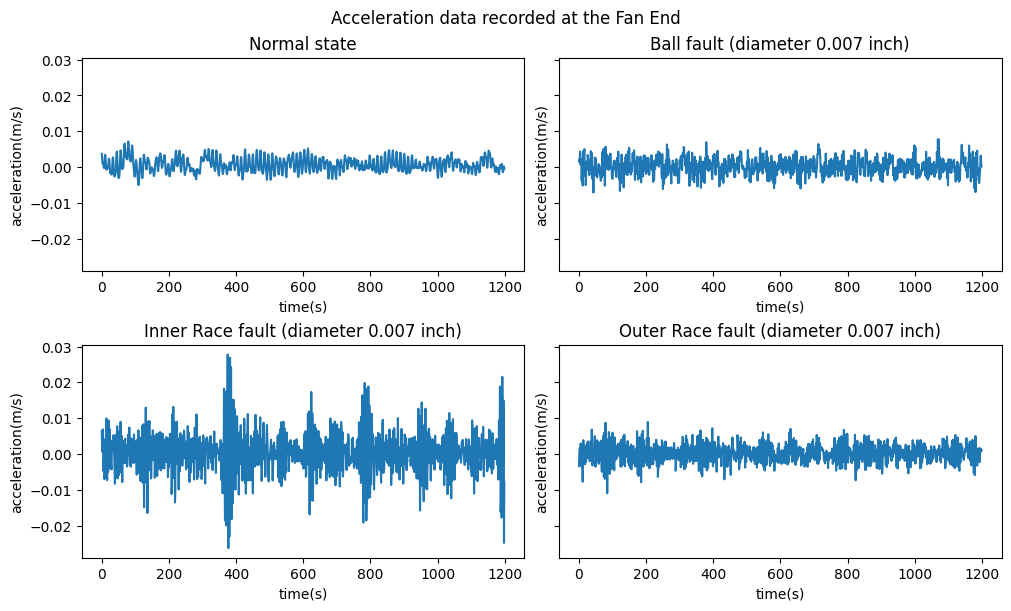

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = range(0,1200)

# plotting
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Fan End')

axs[0, 0].plot(G_data_N_FE_10_perc[range_of_samples])
axs[0, 0].set_title('Normal state')

axs[0, 1].plot(G_data_B_007_10_perc[range_of_samples])
axs[0, 1].set_title('Ball fault (diameter 0.007 inch)')

axs[1, 0].plot(G_data_IR_007_FE_10_perc[range_of_samples])
axs[1, 0].set_title('Inner Race fault (diameter 0.007 inch)')

axs[1, 1].plot(G_data_OR_007_FE_10_perc[range_of_samples])
axs[1, 1].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time(s)', ylabel='acceleration(m/s)')

# 5.Data Chunck
Data in chunks Acceleration data or signal is divided in chunks of size chunk_size and a subset number_of_chunks from all of it that is available for forcasting.

A chunk is simply a sequential subset of the time series data with a fixed length - the chunk_size.

Every chunk is distinct - no overlapping samples in different chunks.

In [11]:
def split_exact(x, n_chunks=2, axis=1):
    import numpy as np
    l = np.shape(x)[axis]
    x_split = x
    if l > n_chunks > 1:
        n = n_chunks
        if axis == 0:
            x_split = np.split(x[:-(l % n)], n, axis=axis)
            #print(x_split)
        elif axis == 1:
            x_split = np.split(x[:, :-(l % n)], n, axis=axis)
    return x_split

In [12]:

import numpy as np

def g_data_chunkSplit(gdata, chunk_size=64):
    """
    Change loaded mat files and splits it in chunks of size chunk_size
    """
    y_n= np.array([])
    # signal
    x = gdata
    x = x / np.std(x)
    y_n = np.append(y_n, x)
    n_splits = len(y_n) // chunk_size
    y_n = split_exact(y_n, n_chunks=n_splits, axis=0)

    return y_n

In [37]:
chunk_size = 16

#FE data
normal_data_chunk_FE = g_data_chunkSplit(G_data_N_FE_10_perc, chunk_size=chunk_size)
print("normal_data_chunk_FE", np.shape(normal_data_chunk_FE))

b_data_chunk_007_FE = g_data_chunkSplit(G_data_B_007_10_perc, chunk_size=chunk_size)
print("b_data_chunk_007_FE", np.shape(b_data_chunk_007_FE))
b_data_chunk_014_FE = g_data_chunkSplit(G_data_B_014_FE_10_perc, chunk_size=chunk_size)
print("b_data_chunk_014_FE", np.shape(b_data_chunk_014_FE))
b_data_chunk_021_FE = g_data_chunkSplit(G_data_B_021_FE_10_perc, chunk_size=chunk_size)
print("b_data_chunk_021_FE", np.shape(b_data_chunk_021_FE))

ir_data_chunk_007_FE = g_data_chunkSplit(G_data_IR_007_FE_10_perc, chunk_size=chunk_size)
print("ir_data_chunk_007_FE", np.shape(ir_data_chunk_007_FE))
ir_data_chunk_014_FE = g_data_chunkSplit(G_data_IR_014_FE_10_perc, chunk_size=chunk_size)
print("ir_data_chunk_014_FE", np.shape(ir_data_chunk_014_FE))
ir_data_chunk_021_FE = g_data_chunkSplit(G_data_IR_021_FE_10_perc, chunk_size=chunk_size)
print("ir_data_chunk_021_FE", np.shape(ir_data_chunk_021_FE))

or_data_chunk_007_FE = g_data_chunkSplit(G_data_OR_007_FE_10_perc, chunk_size=chunk_size)
print("or_data_chunk_007_FE", np.shape(or_data_chunk_007_FE))
or_data_chunk_014_FE = g_data_chunkSplit(G_data_OR_014_FE_10_perc, chunk_size=chunk_size)
print("or_data_chunk_014_FE", np.shape(or_data_chunk_014_FE))
or_data_chunk_021_FE = g_data_chunkSplit(G_data_OR_021_FE_10_perc, chunk_size=chunk_size)
print("or_data_chunk_021_FE", np.shape(or_data_chunk_021_FE))


#DE data
display("DE")
normal_data_chunk_DE = g_data_chunkSplit(G_data_N_DE, chunk_size=chunk_size)
print("normal_data_chunk_DE", np.shape(normal_data_chunk_DE))
ir_data_chunk_007_DE = g_data_chunkSplit(G_data_IR_007_DE, chunk_size=chunk_size)
print("ir_data_chunk_007_DE", np.shape(ir_data_chunk_007_DE))
ir_data_chunk_014_DE = g_data_chunkSplit(G_data_IR_014_DE, chunk_size=chunk_size)
print("ir_data_chunk_014_DE", np.shape(ir_data_chunk_014_DE))
ir_data_chunk_021_DE = g_data_chunkSplit(G_data_IR_021_DE, chunk_size=chunk_size)
print("ir_data_chunk_021_DE", np.shape(ir_data_chunk_021_DE))
ir_data_chunk_028_DE = g_data_chunkSplit(G_data_IR_028_DE, chunk_size=chunk_size)
print("ir_data_chunk_028_DE", np.shape(ir_data_chunk_028_DE))
b_data_chunk_007_DE = g_data_chunkSplit(G_data_B_007_DE, chunk_size=chunk_size)
print("b_data_chunk_007_DE", np.shape(b_data_chunk_007_DE))
b_data_chunk_014_DE = g_data_chunkSplit(G_data_B_014_DE, chunk_size=chunk_size)
print("b_data_chunk_014_DE", np.shape(b_data_chunk_014_DE))
b_data_chunk_021_DE = g_data_chunkSplit(G_data_B_021_DE, chunk_size=chunk_size)
print("b_data_chunk_021_DE", np.shape(b_data_chunk_021_DE))
b_data_chunk_028_DE = g_data_chunkSplit(G_data_B_028_DE, chunk_size=chunk_size)
print("b_data_chunk_028_DE", np.shape(b_data_chunk_028_DE))
or_data_chunk_007_DE = g_data_chunkSplit(G_data_OR_007_DE, chunk_size=chunk_size)
print("or_data_chunk_007_DE", np.shape(or_data_chunk_007_DE))
or_data_chunk_014_DE = g_data_chunkSplit(G_data_OR_014_DE, chunk_size=chunk_size)
print("or_data_chunk_014_DE", np.shape(or_data_chunk_014_DE))
or_data_chunk_021_DE = g_data_chunkSplit(G_data_OR_021_DE, chunk_size=chunk_size)
print("or_data_chunk_021_DE", np.shape(or_data_chunk_021_DE))

normal_data_chunk_FE_train (10615, 16)
normal_data_chunk_FE_test (95543, 16)
b_data_chunk_007_FE_train (3030, 16)
b_data_chunk_007_FE_test (27273, 16)
b_data_chunk_014_FE_train (3045, 16)
b_data_chunk_014_FE_test (27407, 16)
b_data_chunk_021_FE_train (3031, 16)
b_data_chunk_021_FE_test (27283, 16)
ir_data_chunk_007_FE_train (3036, 16)
ir_data_chunk_007_FE_test (27324, 16)
ir_data_chunk_014_FE_train (3032, 16)
ir_data_chunk_014_FE_test (27293, 16)
ir_data_chunk_021_FE_train (3028, 0)
ir_data_chunk_021_FE_test (27252, 16)
or_data_chunk_007_FE_train (9103, 16)
or_data_chunk_007_FE_test (81932, 16)
or_data_chunk_014_FE_train (3785, 16)
or_data_chunk_014_FE_test (34068, 16)
or_data_chunk_021_FE_train (2989, 16)
or_data_chunk_021_FE_test (27210, 16)


'DE'

normal_data_chunk_DE (106159, 16)
ir_data_chunk_007_DE (30519, 16)
ir_data_chunk_014_DE (30452, 16)
ir_data_chunk_021_DE (30470, 16)
ir_data_chunk_028_DE (30314, 16)
b_data_chunk_007_DE (30443, 16)
b_data_chunk_014_DE (30506, 16)
b_data_chunk_021_DE (30497, 16)
b_data_chunk_028_DE (30257, 16)
or_data_chunk_007_DE (91565, 16)
or_data_chunk_014_DE (30488, 16)
or_data_chunk_021_DE (91592, 16)


# 6. Forcasting
## Load model

In [38]:
import timesfm
horizon_len= 16


tfm = timesfm.TimesFm(
    context_len=128,
    horizon_len=horizon_len,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu",  # Or 'gpu' if available
)

tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 5.29 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 4.53 seconds.
Jitting decoding.
Jitted decoding in 29.56 seconds.


## Forcasting on normal data (normal_data_chunk_FE)

In [39]:
data=normal_data_chunk_FE
forecasts, _ = tfm.forecast(inputs=data)

# 6.2 Visualize Forcate result


169840
169840


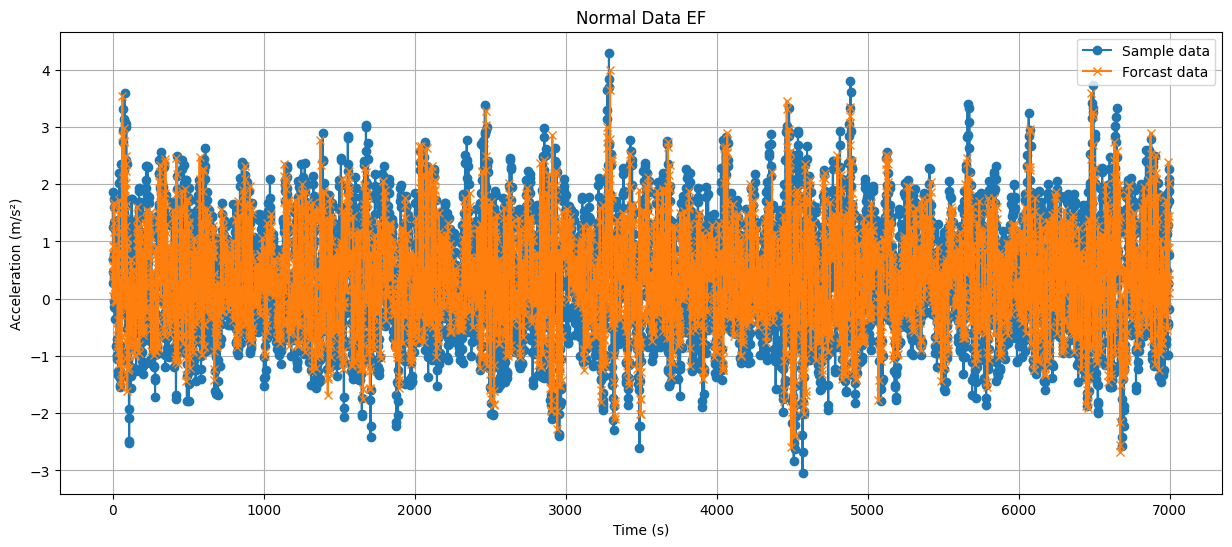

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

data = np.concatenate([i for i in data])
forecasts_concat = np.concatenate([i.reshape(horizon_len) for i in forecasts])
range_of_samples = range(0,7000)
print(len(data))
print(len(forecasts_concat))
# Plotting the concatenated data
plt.figure(figsize=(15, 6))
plt.plot(data[range_of_samples], label='Sample data', linestyle='-', marker='o')
plt.plot(forecasts_concat[range_of_samples], label='Forcast data', linestyle='-', marker='x')
plt.title('Normal Data EF')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()


# 6.3 Show the results
1. MAE
2. MSE
3. RMSE
4. MAPE
5. sMAPE
6. ME

In [47]:
data=G_data_N_FE_10_perc[0:len(forecasts_concat)]

# Calculate MAE
mae = np.mean(np.abs(data - forecasts_concat))
print(f'MAE: {mae}')

# Calculate MSE
mse = np.mean((data - forecasts_concat) ** 2)
print(f'MSE: {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calculate MAPE
mape = np.mean(np.abs((data - forecasts_concat) / data)) * 100
print(f'MAPE: {mape}')

# Calculate sMAPE
smape = np.mean(np.abs(data - forecasts_concat) / ((np.abs(data) + np.abs(forecasts_concat)) / 2)) * 100
print(f'sMAPE: {smape}')

# Calculate ME
me = np.mean(data - forecasts_concat)
print(f'ME: {me}')

MAE: 0.6921609943335281
MSE: 0.7825991107753005
RMSE: 0.8846463195963122
MAPE: inf
sMAPE: 198.10186756567924
ME: -0.4079845558699255


<ipython-input-47-4a5295e9f746>:18: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((normal_data_concat - forecasts_concat) / normal_data_concat)) * 100
